In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf
import  matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.tree import DecisionTreeClassifier


In [74]:
df = pd.read_csv("../BTC_1_year_data_15m.csv").set_index("close_time")
df

,open,high,low,close,volume,open_time,taker_buy_base
close_time,,,,,,,
2024-12-02 12:44:59.999000+00:00,95386.14,95407.64,95080.85,95080.86,299.14374,2024-12-02 12:30:00+00:00,110.43173
2024-12-02 12:59:59.999000+00:00,95080.85,95087.98,94766.00,94972.02,352.27560,2024-12-02 12:45:00+00:00,139.92863
2024-12-02 13:14:59.999000+00:00,94972.03,95490.37,94837.77,95399.83,389.06173,2024-12-02 13:00:00+00:00,213.37077
2024-12-02 13:29:59.999000+00:00,95399.84,95743.66,95397.31,95690.65,478.14614,2024-12-02 13:15:00+00:00,272.74969
2024-12-02 13:44:59.999000+00:00,95690.64,95822.61,95567.44,95577.74,445.23818,2024-12-02 13:30:00+00:00,222.18680
...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,87084.00,87419.99,86993.27,87419.99,239.49429,2025-12-02 11:15:00+00:00,145.59817
2025-12-02 11:44:59.999000+00:00,87419.99,87458.67,87320.01,87329.60,223.03098,2025-12-02 11:30:00+00:00,140.45822
2025-12-02 11:59:59.999000+00:00,87329.60,87602.47,87326.85,87368.92,146.36004,2025-12-02 11:45:00+00:00,93.61402


#### Feature Engineering

In [75]:
df["close_log_return"] = np.log(df["close"]/df["close"].shift())
df["volume_change"] = df["volume"].pct_change().shift()

    Create lagged features

In [76]:
df = df.copy()

In [77]:
def generate_ma_features(df, close_col="close", windows=[5, 10], shift_pct=True):
    """
    Generate moving average and pct-change-to-close features for a list of window sizes.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with at least a 'close' column.
    close_col : str
        Column name for the close price.
    windows : list
        List of integers for rolling windows.
    shift_pct : bool
        Whether to shift pct-change features by 1 step to avoid leakage.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with new features added.
    """
    df = df.copy()

    for w in windows:
        ma_col = f"{w}ma"
        pct_col = f"pct_change_{w}ma_close"

        # Moving average
        df[ma_col] = df[close_col].rolling(w).mean()

        # Percentage difference from MA
        df[pct_col] = (df[close_col] - df[ma_col]) / df[ma_col] * 100

        # Shift to avoid leakage (optional)
        if shift_pct:
            df[pct_col] = df[pct_col].shift()

    return df


windows = [10, 50,200]

df = generate_ma_features(df, windows=windows)


In [78]:
df["close_log_return_lag_1"] = df["close_log_return"].shift()
df["close_log_return_lag_2"] = df["close_log_return"].shift(2)
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)

In [79]:
df["sell_volume"] = df["volume"] - df["taker_buy_base"]

df["buy_sell_pressure"] = (df["taker_buy_base"] - df["sell_volume"]) / df["volume"]
df["buy_sell_pressure_lag1"] = df["buy_sell_pressure"].shift(1)


In [80]:
df = df.dropna(how="any")

    Create binary classification target
        - 1=> Long => Price moves up
        - 0=> Short => Price goes down

In [81]:
df["close_log_return_dir"] = df["close_log_return"].map(lambda x:1 if x>0 else 0)
# df = df.drop(columns="close_log_return")

In [82]:
df

,open,high,low,close,volume,open_time,taker_buy_base,close_log_return,volume_change,10ma,...,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure,buy_sell_pressure_lag1,close_log_return_dir
close_time,,,,,,,,,,,,,,,,,,,,,
2024-12-04 14:44:59.999000+00:00,95780.68,96560.00,95693.05,96349.20,804.71847,2024-12-04 14:30:00+00:00,457.08398,0.005918,-0.329977,95828.210,...,-0.449413,95782.00485,0.005238,0.002851,-0.001648,-0.000026,347.63449,0.136010,0.044281,1
2024-12-04 14:59:59.999000+00:00,96349.20,96377.54,95784.26,95822.99,869.22756,2024-12-04 14:45:00+00:00,418.40142,-0.005476,1.516310,95820.033,...,0.121562,95786.25970,0.592173,0.005918,0.002851,-0.001648,450.82614,-0.037303,0.136010,0
2024-12-04 15:14:59.999000+00:00,95822.99,96386.20,95411.47,96044.01,936.07367,2024-12-04 15:00:00+00:00,506.36306,0.002304,0.080164,95835.668,...,-0.429668,95789.48060,0.038346,-0.005476,0.005918,0.002851,429.71061,0.081887,-0.037303,1
2024-12-04 15:29:59.999000+00:00,96044.01,96212.87,95807.47,96094.73,552.00969,2024-12-04 15:15:00+00:00,251.54963,0.000528,0.076903,95848.343,...,-0.209072,95791.50100,0.265717,0.002304,-0.005476,0.005918,300.46006,-0.088604,0.081887,1
2024-12-04 15:44:59.999000+00:00,96094.74,96154.52,95738.53,95928.03,839.80304,2024-12-04 15:30:00+00:00,390.85216,-0.001736,-0.410292,95850.825,...,-0.162737,95793.25245,0.316551,0.000528,0.002304,-0.005476,448.95088,-0.069181,-0.088604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,87084.00,87419.99,86993.27,87419.99,239.49429,2025-12-02 11:15:00+00:00,145.59817,0.003851,-0.329264,86950.001,...,0.367559,87780.97745,-0.816609,-0.002162,0.002398,0.003057,93.89612,0.215880,-0.127475,1
2025-12-02 11:44:59.999000+00:00,87419.99,87458.67,87320.01,87329.60,223.03098,2025-12-02 11:30:00+00:00,140.45822,-0.001035,0.007008,87017.394,...,0.735136,87760.53735,-0.411237,0.003851,-0.002162,0.002398,82.57276,0.259540,0.215880,0
2025-12-02 11:59:59.999000+00:00,87329.60,87602.47,87326.85,87368.92,146.36004,2025-12-02 11:45:00+00:00,93.61402,0.000450,-0.068742,87067.010,...,0.610582,87740.31660,-0.491038,-0.001035,0.003851,-0.002162,52.74602,0.279229,0.259540,1


In [83]:
df_temp = pd.DataFrame(columns=["close_log_return", "close"])
df_temp[["close_log_return", "close"]] = df[["close_log_return", "close"]]

In [84]:
def drop_ma_columns(df, windows, extra_drop=None):
    """
    Remove moving-average columns after pct-change features are created.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    windows : list
        List of MA windows used (e.g., [5,10,20]).
    extra_drop : list or None
        Additional columns to drop explicitly.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with MA columns removed.
    """
    df = df.copy()

    # ma columns generated earlier
    ma_cols = [f"{w}ma" for w in windows]

    # combine with user-provided columns
    if extra_drop:
        drop_cols = list(set(ma_cols + extra_drop))
    else:
        drop_cols = ma_cols

    # drop only those that actually exist
    drop_cols = [c for c in drop_cols if c in df.columns]

    df = df.drop(columns=drop_cols, errors="ignore")

    return df


df = drop_ma_columns(
    df,
    windows,
    extra_drop=["volume", "close_log_return", "open", "high", "low", "close", 'buy_sell_pressure',"taker_buy_base","open_time"],
)

In [85]:
def plot_feature_scatter(df, sample_size=2000):
    """
    Creates a scatter plot matrix (pairplot) for all features in df.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing numerical features.
    sample_size : int
        Optional sampling to speed up plotting (very important for large datasets).
    """
    
    # Use only numeric columns
    numeric_df = df.select_dtypes(include=["number"]).copy()

    # Optional sampling for speed
    if len(numeric_df) > sample_size:
        numeric_df = numeric_df.sample(sample_size, random_state=42)

    sns.pairplot(numeric_df, diag_kind="kde")
    plt.show()


In [86]:
# plot_feature_scatter(df)

In [87]:
df.head()

,volume_change,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1,close_log_return_dir
close_time,,,,,,,,,,
2024-12-04 14:44:59.999000+00:00,-0.329977,-0.014294,-0.449413,0.005238,0.002851,-0.001648,-0.000026,347.63449,0.044281,1
2024-12-04 14:59:59.999000+00:00,1.516310,0.543671,0.121562,0.592173,0.005918,0.002851,-0.001648,450.82614,0.136010,0
2024-12-04 15:14:59.999000+00:00,0.080164,0.003086,-0.429668,0.038346,-0.005476,0.005918,0.002851,429.71061,-0.037303,1
2024-12-04 15:29:59.999000+00:00,0.076903,0.217395,-0.209072,0.265717,0.002304,-0.005476,0.005918,300.46006,0.081887,1
2024-12-04 15:44:59.999000+00:00,-0.410292,0.257059,-0.162737,0.316551,0.000528,0.002304,-0.005476,448.95088,-0.088604,0


    Check class imbalance

In [88]:
print(df["close_log_return_dir"].value_counts())

close_log_return_dir
0    17461
1    17379
Name: count, dtype: int64


#### Split data into training and testing set but in temporal order

    Feature-Target Split

In [89]:
X = df.iloc[:,:-1 ]
y = df.iloc[:,-1]

In [90]:
# Step 1: 60% train, 40% remaining
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

# Step 2: Split 40% into 50/50 → each gets 20% of original
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [91]:
df_temp["close_log_return"]

close_time
2024-12-04 14:44:59.999000+00:00    0.005918
2024-12-04 14:59:59.999000+00:00   -0.005476
2024-12-04 15:14:59.999000+00:00    0.002304
2024-12-04 15:29:59.999000+00:00    0.000528
2024-12-04 15:44:59.999000+00:00   -0.001736
                                      ...   
2025-12-02 11:29:59.999000+00:00    0.003851
2025-12-02 11:44:59.999000+00:00   -0.001035
2025-12-02 11:59:59.999000+00:00    0.000450
2025-12-02 12:14:59.999000+00:00    0.000909
2025-12-02 12:29:59.999000+00:00   -0.000844
Name: close_log_return, Length: 34840, dtype: float64

In [92]:
def time_split(x, train_size=0.8):
    i = int(len(x) * train_size)
    return x[:i].copy(), x[i:].copy()


df_train_temp, df_test_temp = time_split(df_temp, train_size=0.6)

In [93]:
print(y_train.value_counts())
print(y_test.value_counts())

close_log_return_dir
0    10475
1    10429
Name: count, dtype: int64
close_log_return_dir
0    3513
1    3455
Name: count, dtype: int64


### Scikit-learn Cecision Tree Model

In [94]:
model = DecisionTreeClassifier(max_depth=5)

In [95]:
model.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [96]:
accuracy_score(y_train, model.predict(X_train))

0.585390355912744

In [97]:
accuracy_score(y_test, model.predict(X_test))


0.580654420206659

In [98]:
cm = confusion_matrix(y_test, model.predict(X_test))

#### Hyperparameter Tuning

In [99]:
depth_hyperparams = range(1,50,2)

In [100]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.5542001530807501]
Validation Accuracy Scores: [0.5655855338691159]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372]
Validation Accuracy Scores: [0.5655855338691159, 0.5708955223880597]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.585390355912744]
Validation Accuracy Scores: [0.5655855338691159, 0.5708955223880597, 0.5723306544202067]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.585390355912744]
Validation Accuracy Scores: [0.5655855338691159, 0.5708955223880597, 0.5723306544202067]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.585390355912744]
Validation Accuracy Scores: [0.5655855338691159, 0.5708955223880597, 0.5723306544202067]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.585390355912744]
Validation Accuracy Scores: [0.5655855338691159, 0.5708955223880597, 0.5723306544202067]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0

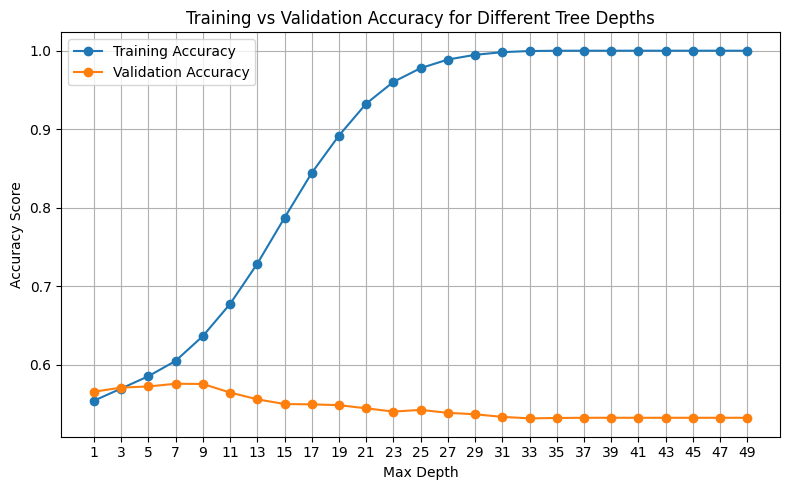

In [101]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()


<p style="color: yellow">TP, FP, TN, FN are purely relative to whatever you declare as the positive class.</p>

    - 1 is UP prediction
    - 0 is DOWN prediction
    - 1 is positive class
    - 0 is negative class



In [102]:
TN = cm[0][0]   #True Down  - When it should be down and model predicted down
FN = cm[1][0]   #False down - When it should be up but the model predicted down
FP = cm[0][1]   #False up   - When it should be down but the model predicted up
TP = cm[1][1]   #True UP    - When it should be up and the model predicted up

In [103]:
print(TN), print(TP), print(FN), print(FN)

2515
1531
1924
1924


(None, None, None, None)

#### Evaluate win rate

    Accuracy Measure

In [104]:
(TP+TN)/(TP+TN+FP+FN) 

np.float64(0.580654420206659)

#### Evaluate the up Predictibility

In [105]:
TP/(TP+FP)

np.float64(0.605377619612495)

#### Evaluate the up Predictibility

<p style="color: yellow; font-size: 20px">Recall</p>
    


In [106]:
TP/(TP+FN)  # Here we are essentially looking at - from all the True classes, how many True classes I predicted correctly

np.float64(0.44312590448625183)

<p style="color: yellow; font-size: 20px">Precision</p>

Precision is, for all of my predictions for a particular class, how many times I was right


In [107]:
TP/(TP+FP) # From all the times I predicted True/UP, How many were actually true/up

np.float64(0.605377619612495)

#### Evaluate down predictability

<p style="color: yellow; font-size: 20px">Recall</p>


In [108]:
TN / (TN+FP) # Here we are essentially looking at - from all the False classes, how many false classes I predicted correctly

np.float64(0.7159123256475947)

<p style="color: yellow; font-size: 20px">Precision</p>


In [109]:
TN / (TN+FN)    # From as many times I predicted false, how many were actually false.

np.float64(0.5665690470826763)

###### **PRECISION**
###### "When I predict UP, how often am I actually right?"

```python
Precision = TP / (TP + FP)
```

**Out of all my UP predictions, how many were actually correct?**

- **Focus:** My predicted UP events (my actions)
- **Fear:** False Positives (wrongly predicting UP when it's actually DOWN)
- **High precision = When I say UP, you can trust me — but I might be missing opportunities**

---

###### **RECALL**
###### "How many actual UP moves did I successfully catch?"

```python
Recall = TP / (TP + FN)
```

**Out of all the real UP days, how many did my model correctly predict as UP?**

- **Focus:** The actual UP events (reality)
- **Fear:** False Negatives (missing UP days)
- **High recall = I catch most of the UP moves, even if I sometimes make wrong predictions**

---

###### **The Key Difference**

| | Precision | Recall |
|---|-----------|--------|
| **Perspective** | YOUR predictions | REALITY's events |
| **Denominator** | What YOU predicted | What ACTUALLY happened |
| **Question** | "Am I accurate?" | "Am I thorough?" |
| **Trading analogy** | "Hit rate of my signals" | "% of opportunities captured" |

---

###### **Trading Strategy Examples**

###### **High Precision, Low Recall Strategy**
- Very selective, only trades slam-dunk setups
- Few trades, but most are winners
- Good for: High transaction costs, limited capital, risk-averse

###### **Low Precision, High Recall Strategy**
- Casts a wide net, takes many signals
- Catches most moves, but many false alarms
- Good for: Low transaction costs, diversification, systematic execution

###### **Balanced Strategy**
- Optimizes F1-score (harmonic mean of precision and recall)
- Trades off some accuracy for better coverage
- Good for: Most real-world trading applications

---

###### **The Trade-off**

You can't maximize both simultaneously:

- ↑ Threshold → ↑ Precision, ↓ Recall (be picky)
- ↓ Threshold → ↓ Precision, ↑ Recall (be aggressive)

**The optimal balance depends on your strategy's economics.**


#### Directional Balance : Short Ratio

In [110]:
short_ratio = (FN+TN)/(FN+TN+FP+FP)
short_ratio

np.float64(0.6898212898212899)

#### Directional Balance: Long Ratio

In [111]:
long_ratio = (FP+TP)/(FN+TN+FP+FP)
long_ratio

np.float64(0.393006993006993)

#### Directional Imbalance

In [112]:
short_ratio/long_ratio

np.float64(1.755239224990115)

#### Evaluating Model's profitabilty (Out-of-sample)

In [113]:
df_test = X_test.copy()

In [114]:
df_test

,volume_change,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1
close_time,,,,,,,,,
2025-09-20 22:44:59.999000+00:00,-0.473983,-0.019660,-0.072475,-0.312732,-0.000225,0.000059,-0.000882,30.18925,-0.175072
2025-09-20 22:59:59.999000+00:00,0.865558,-0.041855,-0.092800,-0.324886,-0.000204,-0.000225,0.000059,19.38370,-0.135347
2025-09-20 23:14:59.999000+00:00,-0.373024,-0.015223,-0.065372,-0.289285,0.000282,-0.000204,-0.000225,9.89016,-0.162684
2025-09-20 23:29:59.999000+00:00,-0.434321,-0.048855,-0.101180,-0.318958,-0.000366,0.000282,-0.000204,15.30591,-0.048716
2025-09-20 23:44:59.999000+00:00,0.596362,-0.058535,-0.110296,-0.321120,-0.000096,-0.000366,0.000282,42.08027,-0.016676
...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,-0.329264,0.263426,0.367559,-0.816609,-0.002162,0.002398,0.003057,93.89612,-0.127475
2025-12-02 11:44:59.999000+00:00,0.007008,0.540528,0.735136,-0.411237,0.003851,-0.002162,0.002398,82.57276,0.215880
2025-12-02 11:59:59.999000+00:00,-0.068742,0.358786,0.610582,-0.491038,-0.001035,0.003851,-0.002162,52.74602,0.259540


In [115]:
model.predict(X_test)

array([0, 0, 1, ..., 1, 1, 0], shape=(6968,))

In [116]:
model.predict_proba(X_test)

array([[0.5110285 , 0.4889715 ],
       [0.5110285 , 0.4889715 ],
       [0.28      , 0.72      ],
       ...,
       [0.46364291, 0.53635709],
       [0.41982864, 0.58017136],
       [0.5110285 , 0.4889715 ]], shape=(6968, 2))

In [117]:
df_test["y_pred_binary"] = model.predict(X_test)
df_test[["close_log_return", "close"]] = df_test_temp[["close_log_return", "close"]]

In [118]:
df_test

,volume_change,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1,y_pred_binary,close_log_return,close
close_time,,,,,,,,,,,,
2025-09-20 22:44:59.999000+00:00,-0.473983,-0.019660,-0.072475,-0.312732,-0.000225,0.000059,-0.000882,30.18925,-0.175072,0,-0.000204,115743.42
2025-09-20 22:59:59.999000+00:00,0.865558,-0.041855,-0.092800,-0.324886,-0.000204,-0.000225,0.000059,19.38370,-0.135347,0,0.000282,115776.06
2025-09-20 23:14:59.999000+00:00,-0.373024,-0.015223,-0.065372,-0.289285,0.000282,-0.000204,-0.000225,9.89016,-0.162684,1,-0.000366,115733.65
2025-09-20 23:29:59.999000+00:00,-0.434321,-0.048855,-0.101180,-0.318958,-0.000366,0.000282,-0.000204,15.30591,-0.048716,0,-0.000096,115722.59
2025-09-20 23:44:59.999000+00:00,0.596362,-0.058535,-0.110296,-0.321120,-0.000096,-0.000366,0.000282,42.08027,-0.016676,0,-0.000726,115638.61
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,-0.329264,0.263426,0.367559,-0.816609,-0.002162,0.002398,0.003057,93.89612,-0.127475,1,0.003851,87419.99
2025-12-02 11:44:59.999000+00:00,0.007008,0.540528,0.735136,-0.411237,0.003851,-0.002162,0.002398,82.57276,0.215880,1,-0.001035,87329.60
2025-12-02 11:59:59.999000+00:00,-0.068742,0.358786,0.610582,-0.491038,-0.001035,0.003851,-0.002162,52.74602,0.259540,1,0.000450,87368.92


#### Add Directional Signal

In [119]:
df_test["dir_signal"] = np.where(
    df_test["y_pred_binary"] == 1, 1, -1
)  # We have just replaced the zeroes with -1
df_test[["close_log_return", "y_pred_binary", "dir_signal"]]

,close_log_return,y_pred_binary,dir_signal
close_time,,,
2025-09-20 22:44:59.999000+00:00,-0.000204,0,-1
2025-09-20 22:59:59.999000+00:00,0.000282,0,-1
2025-09-20 23:14:59.999000+00:00,-0.000366,1,1
2025-09-20 23:29:59.999000+00:00,-0.000096,0,-1
2025-09-20 23:44:59.999000+00:00,-0.000726,0,-1
...,...,...,...
2025-12-02 11:29:59.999000+00:00,0.003851,1,1
2025-12-02 11:44:59.999000+00:00,-0.001035,1,1
2025-12-02 11:59:59.999000+00:00,0.000450,1,1


In [120]:
df_test[["close_log_return", "y_pred_binary", "dir_signal"]].tail()

,close_log_return,y_pred_binary,dir_signal
close_time,,,
2025-12-02 11:29:59.999000+00:00,0.003851,1,1
2025-12-02 11:44:59.999000+00:00,-0.001035,1,1
2025-12-02 11:59:59.999000+00:00,0.000450,1,1
2025-12-02 12:14:59.999000+00:00,0.000909,1,1
2025-12-02 12:29:59.999000+00:00,-0.000844,0,-1


In [121]:

# Identify when signal actually changes (actual trades)
df_test["signal_change"] = df_test["dir_signal"].diff().fillna(0)
df_test["trade_occurred"] = (df_test["signal_change"] != 0).astype(int)

# Calculate gross returns
df_test["trade_log_return"] = df_test["dir_signal"] * df_test["close_log_return"]
df_test["trade_simple_return"] = np.exp(df_test["trade_log_return"]) - 1

# Apply transaction cost ONLY on trades
transaction_cost = 0.00075  # 0.1%
df_test["trade_cost"] = df_test["trade_occurred"] * transaction_cost

# Net return after costs
df_test["trade_simple_return_net"] = df_test["trade_simple_return"] - df_test["trade_cost"]

# PnL calculation
df_test["trade_pnl"] = 100 * df_test["trade_simple_return_net"]
df_test["cumulative_pnl"] = df_test["trade_pnl"].cumsum()

# Diagnostic
print(f"Total bars: {len(df_test)}")
print(f"Actual trades: {df_test['trade_occurred'].sum()}")
print(f"Total transaction costs: ${df_test['trade_cost'].sum() * 100:.2f}")

Total bars: 6968
Actual trades: 2580
Total transaction costs: $193.50


In [122]:
# What's the gross cumulative PnL?
df_test["gross_pnl"] = 100 * df_test["trade_simple_return"]
print(f"Gross final PnL: ${df_test['gross_pnl'].sum():.2f}")

# What's the net cumulative PnL?
print(f"Net final PnL: ${df_test['trade_pnl'].sum():.2f}")

# Difference should equal transaction costs
print(f"Difference: ${df_test['gross_pnl'].sum() - df_test['trade_pnl'].sum():.2f}")

Gross final PnL: $268.82
Net final PnL: $75.32
Difference: $193.50


#### Add trade log return

<Axes: title={'center': 'Cumulative Log Return After Transaction Costs'}, xlabel='Time', ylabel='Cumulative Log Return'>

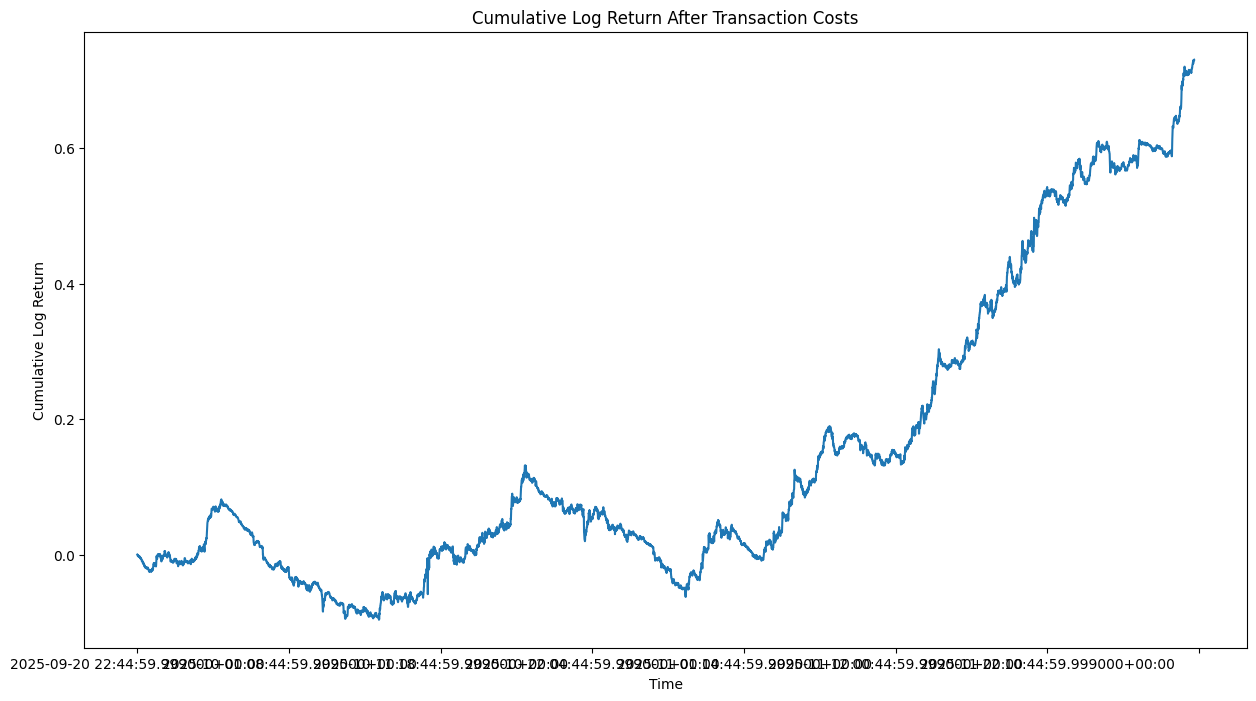

In [123]:
# Step 1: Identify actual trades (when position changes)
df_test["signal_change"] = df_test["dir_signal"].diff().fillna(0)
df_test["is_trade"] = (df_test["signal_change"] != 0).astype(int)

# Step 2: Calculate position log returns
df_test["trade_log_return"] = df_test["dir_signal"] * df_test["close_log_return"]

# Step 3: Apply transaction cost in log return space
# Convert 0.075% to log return: log(1 - 0.00075) ≈ -0.000750281
transaction_cost_log = np.log(1 - 0.00075)  # ≈ -0.000750281
df_test["trade_cost_log"] = df_test["is_trade"] * transaction_cost_log

# Step 4: Net log return after transaction cost
df_test["trade_log_return_net"] = df_test["trade_log_return"] + df_test["trade_cost_log"]

# Step 5: Cumulative log return
df_test["cum_trade_log_return"] = df_test["trade_log_return_net"].cumsum()

# Plot
df_test["cum_trade_log_return"].plot(figsize=(15, 8),
                                      title="Cumulative Log Return After Transaction Costs",
                                      xlabel="Time",
                                      ylabel="Cumulative Log Return")

#### Compound growth returns (Log returns are time additive)

<Axes: xlabel='close_time'>

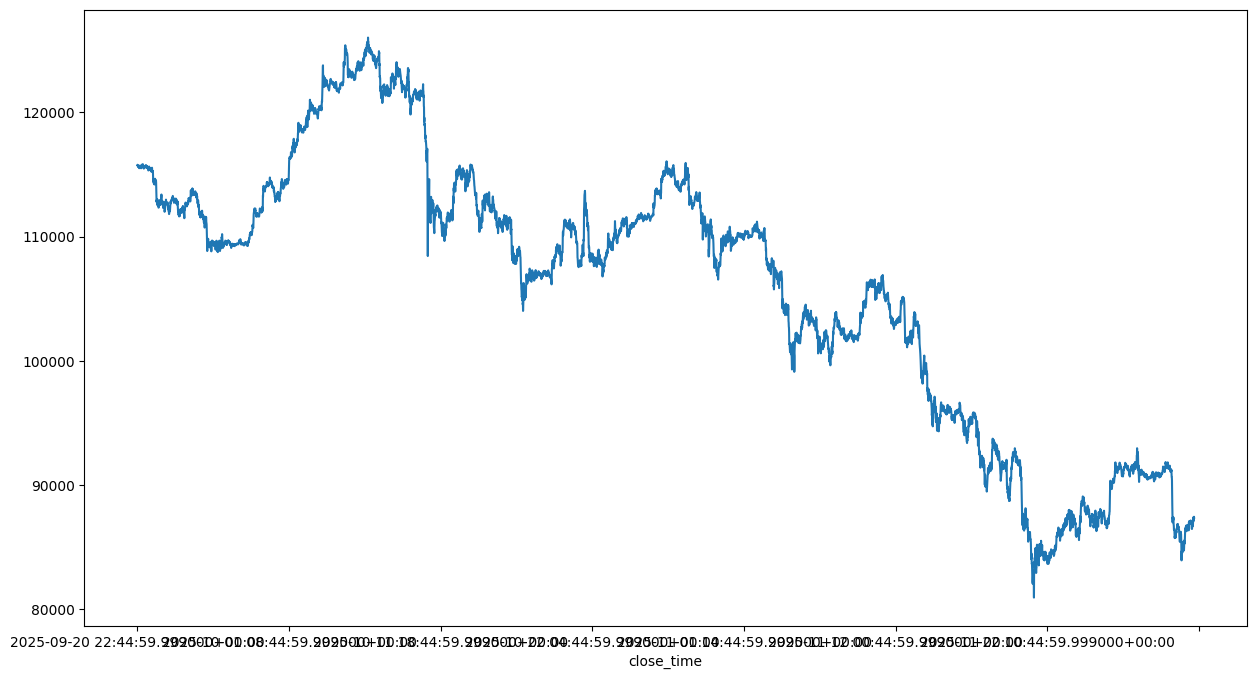

In [124]:
df_test["close"].plot(figsize=(15, 8))

#### Display Equity curve

In [125]:
intial_capital = 100

<Axes: xlabel='close_time'>

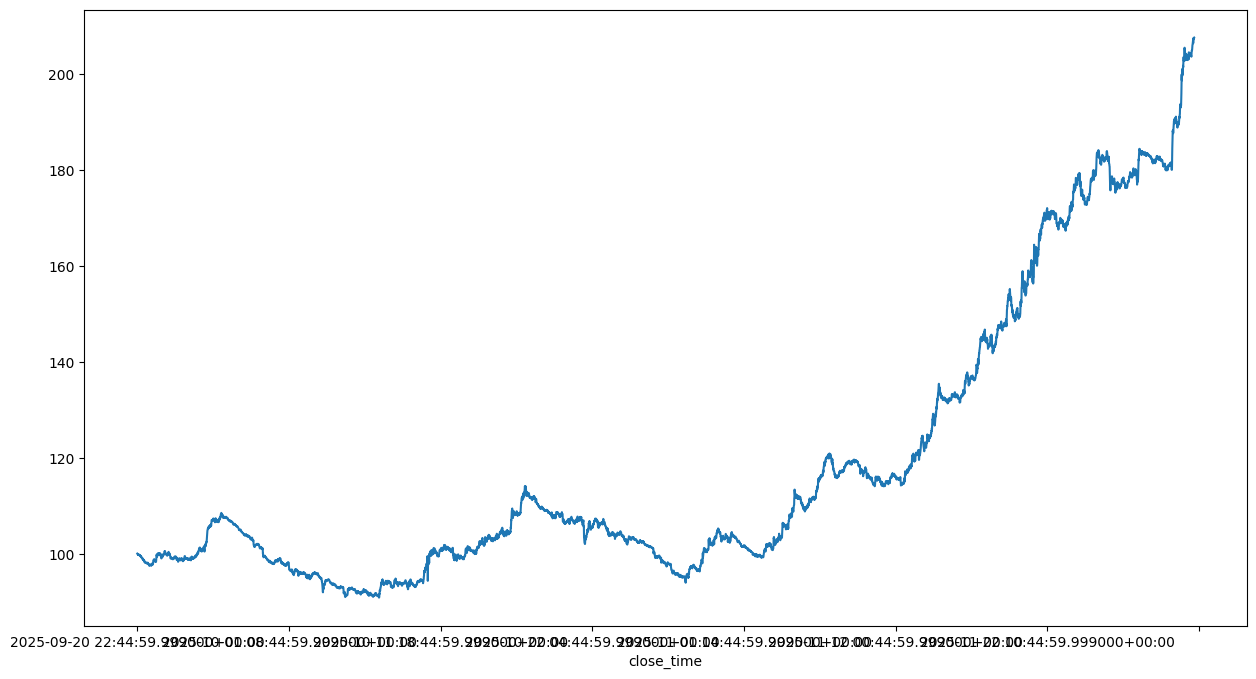

In [126]:
df_test["trade_gross_pnl"] = np.exp(df_test["cum_trade_log_return"]) * intial_capital
df_test["trade_gross_pnl"].plot(figsize=(15, 8))

#### Evaluate total compound return

In [127]:
total_compound_return = np.exp(df_test["trade_log_return"].sum())
total_compound_return

np.float64(14.38738559569389)

#### Evaluate Gross PnL

In [128]:
total_compound_return * intial_capital

np.float64(1438.738559569389)

In [129]:
# Initial capital
initial_capital = 100  # $100

# Step 1: Calculate GROSS compound return (without fees)
gross_cumulative_log_return = df_test["trade_log_return"].sum()
gross_compound_return = np.exp(gross_cumulative_log_return)
gross_final_capital = gross_compound_return * initial_capital
gross_pnl = gross_final_capital - initial_capital

# Step 2: Calculate NET compound return (with fees)
net_cumulative_log_return = df_test["trade_log_return_net"].sum()
net_compound_return = np.exp(net_cumulative_log_return)
net_final_capital = net_compound_return * initial_capital
net_pnl = net_final_capital - initial_capital

# Step 3: Display results
print("="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"\nTotal Trades: {df_test['is_trade'].sum()}")
print(f"Total Bars: {len(df_test)}")
print(f"\n--- GROSS (Before Fees) ---")
print(f"Cumulative Log Return: {gross_cumulative_log_return:.4f}")
print(f"Compound Return: {(gross_compound_return - 1) * 100:.2f}%")
print(f"Final Capital: ${gross_final_capital:.2f}")
print(f"Gross PnL: ${gross_pnl:.2f}")

print(f"\n--- NET (After 0.075% Fees) ---")
print(f"Cumulative Log Return: {net_cumulative_log_return:.4f}")
print(f"Compound Return: {(net_compound_return - 1) * 100:.2f}%")
print(f"Final Capital: ${net_final_capital:.2f}")
print(f"Net PnL: ${net_pnl:.2f}")

print(f"\n--- COST ANALYSIS ---")
print(f"Transaction Costs: ${gross_pnl - net_pnl:.2f}")
print(f"Cost as % of Gross PnL: {((gross_pnl - net_pnl) / gross_pnl * 100):.2f}%")
print("="*60)

PERFORMANCE SUMMARY
Initial Capital: $100.00

Total Trades: 2580
Total Bars: 6968

--- GROSS (Before Fees) ---
Cumulative Log Return: 2.6664
Compound Return: 1338.74%
Final Capital: $1438.74
Gross PnL: $1338.74

--- NET (After 0.075% Fees) ---
Cumulative Log Return: 0.7306
Compound Return: 107.64%
Final Capital: $207.64
Net PnL: $107.64

--- COST ANALYSIS ---
Transaction Costs: $1231.10
Cost as % of Gross PnL: 91.96%


#### Individual trade returns without compounding

<Axes: xlabel='close_time'>

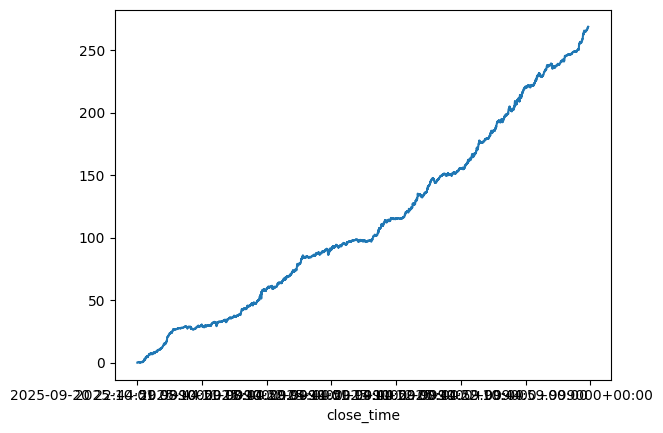

In [130]:
# Convert log return to simple return for each trade
df_test["trade_simple_return"] = np.exp(df_test["trade_log_return"]) - 1

# PnL per trade = $100 * simple return
df_test["trade_pnl"] = 100 * df_test["trade_simple_return"]

# Cumulative PnL = sum of all individual trade PnLs
df_test["cumulative_pnl"] = df_test["trade_pnl"].cumsum()

df_test["cumulative_pnl"].plot()

#### Actual PNL after taking transaction fees into account

<Axes: xlabel='close_time'>

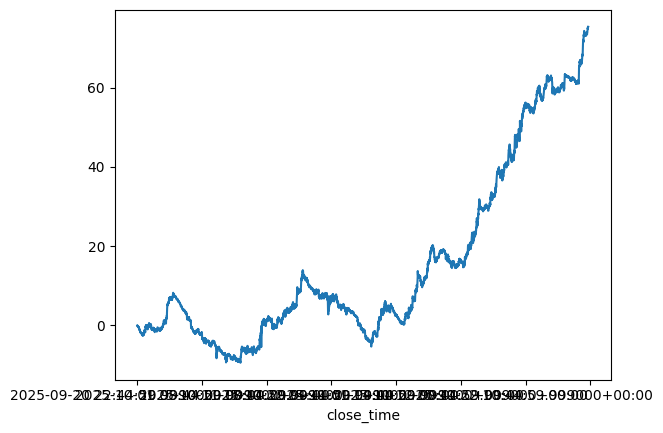

In [131]:
# Step 1: Identify actual trades
df_test["signal_change"] = df_test["dir_signal"].diff().fillna(0)
df_test["is_trade"] = (df_test["signal_change"] != 0).astype(int)

# Step 2: Calculate returns
df_test["trade_simple_return"] = np.exp(df_test["trade_log_return"]) - 1

# Step 3: Apply cost ONLY on trades (0.075% = 0.00075 in decimal)
transaction_cost_pct = 0.00075
df_test["trade_cost"] = df_test["is_trade"] * transaction_cost_pct

# Step 4: Net return after cost
df_test["trade_simple_return_net"] = df_test["trade_simple_return"] - df_test["trade_cost"]

# Step 5: Calculate PnL
df_test["trade_pnl"] = 100 * df_test["trade_simple_return_net"]
df_test["cumulative_pnl"] = df_test["trade_pnl"].cumsum()

df_test["cumulative_pnl"].plot()

#### Total percentage returns without compounding

In [132]:
total_return = df_test["trade_pnl"].sum() / 100
total_return_pct = total_return * 100
print(f"Total Return: {total_return_pct:.2f}%")

Total Return: 75.32%


### Testing on the whole data

MODEL PERFORMANCE ACROSS ALL DATA SPLITS
Train Set (20904 samples, 60%):
  Accuracy: 58.54%

Validation Set (6968 samples, 20%):
  Accuracy: 57.23%

Test Set (6968 samples, 20%):
  Accuracy: 58.07%

Overall (34840 samples, 100%):
  Accuracy: 58.18%

Generalization Gaps:
  Train-Val Gap: 1.31%
  Train-Test Gap: 0.47%
  Val-Test Gap: -0.83%

Predictions added to dataframe with columns:
  - y_pred_binary: Binary predictions (0 or 1)
  - y_pred_proba: Probability of class 1
  - prediction_correct: Whether prediction matches actual
  - data_split: Which split (train/val/test)

DETAILED CLASSIFICATION REPORTS

--- TRAIN SET ---
              precision    recall  f1-score   support

     Class 0       0.57      0.74      0.64     10475
     Class 1       0.62      0.43      0.51     10429

    accuracy                           0.59     20904
   macro avg       0.59      0.59      0.57     20904
weighted avg       0.59      0.59      0.57     20904


--- VALIDATION SET ---
              preci

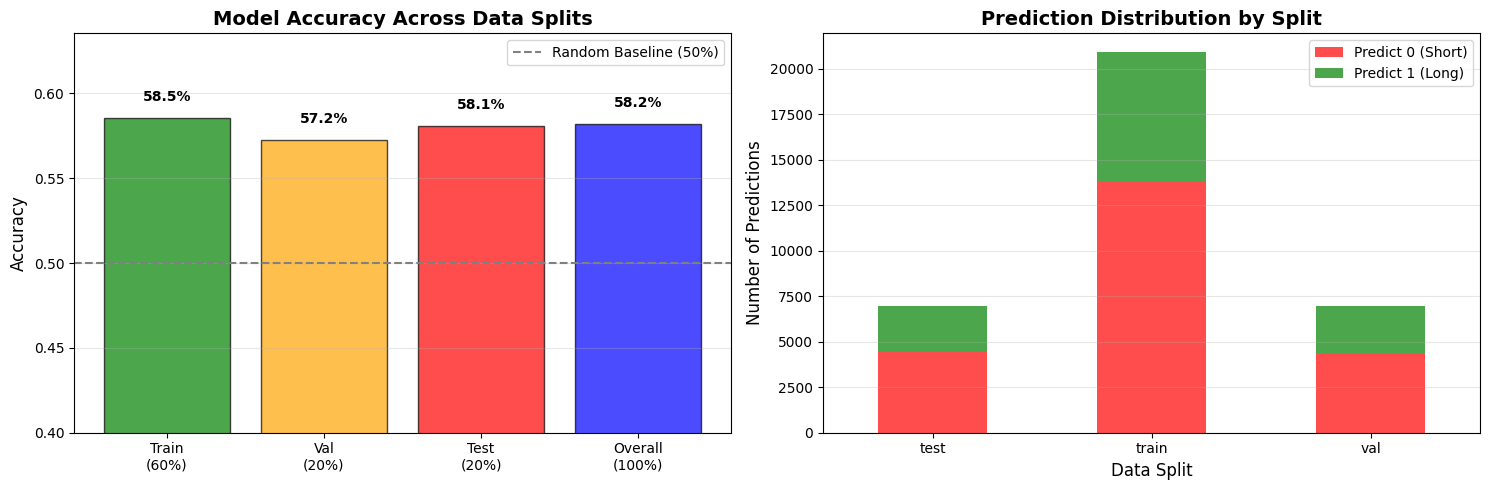


PREDICTION DISTRIBUTION
predicted      0     1
split                 
test        4439  2529
train      13768  7136
val         4345  2623

Prediction Balance:
predicted
0    0.647302
1    0.352698
Name: proportion, dtype: float64


In [133]:
# Train the model on training data
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Generate predictions for ALL data (entire X, y)
y_pred_all = model.predict(X)
y_pred_proba_all = model.predict_proba(X)[:, 1]  # Probability of class 1

# Calculate accuracy for each split
from sklearn.metrics import accuracy_score, classification_report

# Determine split indices
train_size = len(X_train)
val_size = len(X_val)
test_size = len(X_test)

# Split predictions by original data splits
y_pred_train = y_pred_all[:train_size]
y_pred_val = y_pred_all[train_size:train_size + val_size]
y_pred_test = y_pred_all[train_size + val_size:]

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
test_accuracy = accuracy_score(y_test, y_pred_test)
overall_accuracy = accuracy_score(y, y_pred_all)

# Display results
print("="*70)
print("MODEL PERFORMANCE ACROSS ALL DATA SPLITS")
print("="*70)
print(f"Train Set ({len(X_train)} samples, 60%):")
print(f"  Accuracy: {train_accuracy:.2%}")
print(f"\nValidation Set ({len(X_val)} samples, 20%):")
print(f"  Accuracy: {val_accuracy:.2%}")
print(f"\nTest Set ({len(X_test)} samples, 20%):")
print(f"  Accuracy: {test_accuracy:.2%}")
print(f"\nOverall ({len(X)} samples, 100%):")
print(f"  Accuracy: {overall_accuracy:.2%}")
print(f"\nGeneralization Gaps:")
print(f"  Train-Val Gap: {train_accuracy - val_accuracy:.2%}")
print(f"  Train-Test Gap: {train_accuracy - test_accuracy:.2%}")
print(f"  Val-Test Gap: {val_accuracy - test_accuracy:.2%}")
print("="*70)

# Create DataFrame with all predictions for further analysis
df_all_predictions = pd.DataFrame({
    'actual': y,
    'predicted': y_pred_all,
    'predicted_proba': y_pred_proba_all,
    'correct': y == y_pred_all,
    'split': ['train'] * train_size + ['val'] * val_size + ['test'] * test_size
})

# Add to your original dataframe if indices match
if len(df_all_predictions) == len(df):  # Assuming df is your main dataframe
    df['y_pred_binary'] = y_pred_all
    df['y_pred_proba'] = y_pred_proba_all
    df['prediction_correct'] = df_all_predictions['correct']
    df['data_split'] = df_all_predictions['split']

print("\nPredictions added to dataframe with columns:")
print("  - y_pred_binary: Binary predictions (0 or 1)")
print("  - y_pred_proba: Probability of class 1")
print("  - prediction_correct: Whether prediction matches actual")
print("  - data_split: Which split (train/val/test)")

# Detailed classification report for each split
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORTS")
print("="*70)

print("\n--- TRAIN SET ---")
print(classification_report(y_train, y_pred_train, target_names=['Class 0', 'Class 1']))

print("\n--- VALIDATION SET ---")
print(classification_report(y_val, y_pred_val, target_names=['Class 0', 'Class 1']))

print("\n--- TEST SET ---")
print(classification_report(y_test, y_pred_test, target_names=['Class 0', 'Class 1']))

# Visualize accuracy across splits
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Accuracy comparison
splits = ['Train\n(60%)', 'Val\n(20%)', 'Test\n(20%)', 'Overall\n(100%)']
accuracies = [train_accuracy, val_accuracy, test_accuracy, overall_accuracy]
colors = ['green', 'orange', 'red', 'blue']

axes[0].bar(splits, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.5, color='gray', linestyle='--', label='Random Baseline (50%)')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Across Data Splits', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.4, max(accuracies) + 0.05])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (split, acc) in enumerate(zip(splits, accuracies)):
    axes[0].text(i, acc + 0.01, f'{acc:.1%}', ha='center', fontweight='bold')

# Plot 2: Prediction distribution by split
split_counts = df_all_predictions.groupby(['split', 'predicted']).size().unstack(fill_value=0)
split_counts.plot(kind='bar', stacked=True, ax=axes[1], color=['red', 'green'], alpha=0.7)
axes[1].set_title('Prediction Distribution by Split', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Data Split', fontsize=12)
axes[1].set_ylabel('Number of Predictions', fontsize=12)
axes[1].legend(['Predict 0 (Short)', 'Predict 1 (Long)'], loc='upper right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("PREDICTION DISTRIBUTION")
print("="*70)
print(df_all_predictions.groupby(['split', 'predicted']).size().unstack(fill_value=0))
print("\nPrediction Balance:")
print(df_all_predictions['predicted'].value_counts(normalize=True))

Model is conservative on long signals (61% precision, 44% recall)

When it says "go long," it's right 61% of the time
But it misses some long opportunities (44% recall)


Model is aggressive on short signals (57% precision, 72% recall)

Catches most short opportunities (72% recall)
But with slightly lower precision (57%)

In [134]:
df

,volume_change,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1,close_log_return_dir,y_pred_binary,y_pred_proba,prediction_correct,data_split
close_time,,,,,,,,,,,,,,
2024-12-04 14:44:59.999000+00:00,-0.329977,-0.014294,-0.449413,0.005238,0.002851,-0.001648,-0.000026,347.63449,0.044281,1,1,0.531056,True,train
2024-12-04 14:59:59.999000+00:00,1.516310,0.543671,0.121562,0.592173,0.005918,0.002851,-0.001648,450.82614,0.136010,0,0,0.487761,True,train
2024-12-04 15:14:59.999000+00:00,0.080164,0.003086,-0.429668,0.038346,-0.005476,0.005918,0.002851,429.71061,-0.037303,1,0,0.320090,False,train
2024-12-04 15:29:59.999000+00:00,0.076903,0.217395,-0.209072,0.265717,0.002304,-0.005476,0.005918,300.46006,0.081887,1,0,0.487761,False,train
2024-12-04 15:44:59.999000+00:00,-0.410292,0.257059,-0.162737,0.316551,0.000528,0.002304,-0.005476,448.95088,-0.088604,0,0,0.487761,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,-0.329264,0.263426,0.367559,-0.816609,-0.002162,0.002398,0.003057,93.89612,-0.127475,1,1,0.722581,True,test
2025-12-02 11:44:59.999000+00:00,0.007008,0.540528,0.735136,-0.411237,0.003851,-0.002162,0.002398,82.57276,0.215880,0,1,0.539202,False,test
2025-12-02 11:59:59.999000+00:00,-0.068742,0.358786,0.610582,-0.491038,-0.001035,0.003851,-0.002162,52.74602,0.259540,1,1,0.536357,True,test


In [135]:

df = pd.read_csv("../BTC_1_year_data_15m.csv").set_index("close_time")


# Assuming df has 'close_log_return' column already
df["close_log_return"] = np.log(df["close"]/df["close"].shift())
df["volume_change"] = df["volume"].pct_change().shift()

df = generate_ma_features(df, windows=windows)

df["close_log_return_lag_1"] = df["close_log_return"].shift()
df["close_log_return_lag_2"] = df["close_log_return"].shift(2)
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)

df["sell_volume"] = df["volume"] - df["taker_buy_base"]

df["buy_sell_pressure"] = (df["taker_buy_base"] - df["sell_volume"]) / df["volume"]
df["buy_sell_pressure_lag1"] = df["buy_sell_pressure"].shift(1)

df = df.dropna(how="any")

df["close_log_return_dir"] = df["close_log_return"].map(lambda x:1 if x>0 else 0)
print(len(df))

df_temp = pd.DataFrame(columns=["close_log_return", "close"])
df_temp[["close_log_return", "close"]] = df[["close_log_return", "close"]]

df = drop_ma_columns(
    df,
    windows,
    extra_drop=["volume", "close_log_return", "open", "high", "low", "close", 'buy_sell_pressure',"taker_buy_base","open_time"],
)

34840


In [136]:
X = df.iloc[:,:-1 ]
y = df.iloc[:,-1]

In [137]:
len(X)

34840

In [138]:
X

,volume_change,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1
close_time,,,,,,,,,
2024-12-04 14:44:59.999000+00:00,-0.329977,-0.014294,-0.449413,0.005238,0.002851,-0.001648,-0.000026,347.63449,0.044281
2024-12-04 14:59:59.999000+00:00,1.516310,0.543671,0.121562,0.592173,0.005918,0.002851,-0.001648,450.82614,0.136010
2024-12-04 15:14:59.999000+00:00,0.080164,0.003086,-0.429668,0.038346,-0.005476,0.005918,0.002851,429.71061,-0.037303
2024-12-04 15:29:59.999000+00:00,0.076903,0.217395,-0.209072,0.265717,0.002304,-0.005476,0.005918,300.46006,0.081887
2024-12-04 15:44:59.999000+00:00,-0.410292,0.257059,-0.162737,0.316551,0.000528,0.002304,-0.005476,448.95088,-0.088604
...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,-0.329264,0.263426,0.367559,-0.816609,-0.002162,0.002398,0.003057,93.89612,-0.127475
2025-12-02 11:44:59.999000+00:00,0.007008,0.540528,0.735136,-0.411237,0.003851,-0.002162,0.002398,82.57276,0.215880
2025-12-02 11:59:59.999000+00:00,-0.068742,0.358786,0.610582,-0.491038,-0.001035,0.003851,-0.002162,52.74602,0.259540


In [139]:


df["y_pred_binary"] = model.predict(X)

df[["close_log_return", "close"]] = df_temp[["close_log_return", "close"]]


# Create directional signal for entire dataset
df["dir_signal"] = np.where(df["y_pred_binary"] == 1, 1, -1)

# Identify trades (when position changes)
df["signal_change"] = df["dir_signal"].diff().fillna(0)
df["is_trade"] = (df["signal_change"] != 0).astype(int)

# Calculate position returns
df["trade_log_return"] = df["dir_signal"] * df["close_log_return"]
df["trade_simple_return"] = np.exp(df["trade_log_return"]) - 1

# Apply transaction costs (0.075% per trade)
transaction_cost_pct = 0.00075  # 0.075% as decimal
df["trade_cost"] = df["is_trade"] * transaction_cost_pct

# Net returns after transaction costs
df["trade_log_return_net"] = df["trade_log_return"] + np.log(1 - df["trade_cost"])
df["trade_simple_return_net"] = df["trade_simple_return"] - df["trade_cost"]

# Calculate PnL
initial_capital = 100
df["trade_pnl"] = initial_capital * df["trade_simple_return_net"]
df["cumulative_pnl"] = df["trade_pnl"].cumsum()

# ============================================================
# PERFORMANCE SUMMARY - ENTIRE DATASET
# ============================================================

# Step 1: Calculate GROSS compound return (without fees)
gross_cumulative_log_return = df["trade_log_return"].sum()
gross_compound_return = np.exp(gross_cumulative_log_return)
gross_final_capital = gross_compound_return * initial_capital
gross_pnl = gross_final_capital - initial_capital

# Step 2: Calculate NET compound return (with fees)
net_cumulative_log_return = df["trade_log_return_net"].sum()
net_compound_return = np.exp(net_cumulative_log_return)
net_final_capital = net_compound_return * initial_capital
net_pnl = net_final_capital - initial_capital

# Step 3: Display results
print("="*70)
print("PERFORMANCE SUMMARY - ENTIRE DATASET (TRAIN + VAL + TEST)")
print("="*70)
print(f"Initial Capital: ${initial_capital:.2f}")
print(f"\nTotal Trades: {df['is_trade'].sum()}")
print(f"Total Bars: {len(df)}")
print(f"Time Period: {df.index[0]} to {df.index[-1]}")

print(f"\n--- GROSS (Before Fees) ---")
print(f"Cumulative Log Return: {gross_cumulative_log_return:.4f}")
print(f"Compound Return: {(gross_compound_return - 1) * 100:.2f}%")
print(f"Final Capital: ${gross_final_capital:.2f}")
print(f"Gross PnL: ${gross_pnl:.2f}")

print(f"\n--- NET (After 0.075% Fees) ---")
print(f"Cumulative Log Return: {net_cumulative_log_return:.4f}")
print(f"Compound Return: {(net_compound_return - 1) * 100:.2f}%")
print(f"Final Capital: ${net_final_capital:.2f}")
print(f"Net PnL: ${net_pnl:.2f}")

print(f"\n--- COST ANALYSIS ---")
print(f"Transaction Costs: ${gross_pnl - net_pnl:.2f}")
print(f"Cost as % of Gross PnL: {((gross_pnl - net_pnl) / gross_pnl * 100):.2f}%")
print(f"Average Cost per Trade: ${(gross_pnl - net_pnl) / df['is_trade'].sum():.4f}")
print(f"Average Gross Profit per Trade: ${gross_pnl / df['is_trade'].sum():.4f}")
print(f"Average Net Profit per Trade: ${net_pnl / df['is_trade'].sum():.4f}")
print("="*70)


PERFORMANCE SUMMARY - ENTIRE DATASET (TRAIN + VAL + TEST)
Initial Capital: $100.00

Total Trades: 12831
Total Bars: 34840
Time Period: 2024-12-04 14:44:59.999000+00:00 to 2025-12-02 12:29:59.999000+00:00

--- GROSS (Before Fees) ---
Cumulative Log Return: 11.8063
Compound Return: 13409173.46%
Final Capital: $13409273.46
Gross PnL: $13409173.46

--- NET (After 0.075% Fees) ---
Cumulative Log Return: 2.1794
Compound Return: 784.12%
Final Capital: $884.12
Net PnL: $784.12

--- COST ANALYSIS ---
Transaction Costs: $13408389.34
Cost as % of Gross PnL: 99.99%
Average Cost per Trade: $1044.9996
Average Gross Profit per Trade: $1045.0607
Average Net Profit per Trade: $0.0611


In [143]:
print(df.index)

Index(['2024-12-04 14:44:59.999000+00:00', '2024-12-04 14:59:59.999000+00:00',
       '2024-12-04 15:14:59.999000+00:00', '2024-12-04 15:29:59.999000+00:00',
       '2024-12-04 15:44:59.999000+00:00', '2024-12-04 15:59:59.999000+00:00',
       '2024-12-04 16:14:59.999000+00:00', '2024-12-04 16:29:59.999000+00:00',
       '2024-12-04 16:44:59.999000+00:00', '2024-12-04 16:59:59.999000+00:00',
       ...
       '2025-12-02 10:14:59.999000+00:00', '2025-12-02 10:29:59.999000+00:00',
       '2025-12-02 10:44:59.999000+00:00', '2025-12-02 10:59:59.999000+00:00',
       '2025-12-02 11:14:59.999000+00:00', '2025-12-02 11:29:59.999000+00:00',
       '2025-12-02 11:44:59.999000+00:00', '2025-12-02 11:59:59.999000+00:00',
       '2025-12-02 12:14:59.999000+00:00', '2025-12-02 12:29:59.999000+00:00'],
      dtype='object', name='close_time', length=34840)


In [144]:
# ============================================================
# ADDITIONAL RISK METRICS - ENTIRE DATASET
# ============================================================
print("\n" + "="*70)
print("ADDITIONAL RISK METRICS - ENTIRE DATASET")
print("="*70)

# Calculate daily returns (extract date from index)
df['date'] = pd.to_datetime(df.index).date
daily_returns = df.groupby('date')['trade_simple_return_net'].sum()

# Sharpe Ratio (annualized, assuming 365 trading days)
mean_daily_return = daily_returns.mean()
std_daily_return = daily_returns.std()
sharpe_ratio = (mean_daily_return / std_daily_return) * np.sqrt(365) if std_daily_return > 0 else 0

# Maximum Drawdown
cumulative_pnl = df['cumulative_pnl']
running_max_pnl = cumulative_pnl.expanding().max()
drawdown_pnl = cumulative_pnl - running_max_pnl
max_drawdown = drawdown_pnl.min()

# Win Rate
winning_trades = (df[df['is_trade'] == 1]['trade_simple_return_net'] > 0).sum()
total_trades = df['is_trade'].sum()
win_rate = winning_trades / total_trades if total_trades > 0 else 0

# Display metrics
print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: ${max_drawdown:.2f}")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Total Trading Days: {len(daily_returns)}")
print(f"Average Daily Return: {mean_daily_return * 100:.4f}%")
print(f"Daily Return Volatility: {std_daily_return * 100:.4f}%")
print("="*70)


ADDITIONAL RISK METRICS - ENTIRE DATASET
Sharpe Ratio (Annualized): 3.76
Maximum Drawdown: $-75.25
Win Rate: 38.05%
Total Trading Days: 364
Average Daily Return: 0.6283%
Daily Return Volatility: 3.1939%


In [145]:
# Add this to check win/loss distribution
print("\n" + "="*70)
print("WIN/LOSS ANALYSIS")
print("="*70)

# Get all actual trades (where is_trade = 1)
trades_only = df[df['is_trade'] == 1].copy()

# Winners and losers
winners = trades_only[trades_only['trade_simple_return_net'] > 0]
losers = trades_only[trades_only['trade_simple_return_net'] <= 0]

# Statistics
avg_win = winners['trade_simple_return_net'].mean() if len(winners) > 0 else 0
avg_loss = losers['trade_simple_return_net'].mean() if len(losers) > 0 else 0
win_loss_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else 0

print(f"Total Trades: {len(trades_only)}")
print(f"Winning Trades: {len(winners)} ({len(winners)/len(trades_only)*100:.2f}%)")
print(f"Losing Trades: {len(losers)} ({len(losers)/len(trades_only)*100:.2f}%)")
print(f"\nAverage Winner: {avg_win*100:.4f}%")
print(f"Average Loser: {avg_loss*100:.4f}%")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}x")
print(f"\nLargest Winner: {winners['trade_simple_return_net'].max()*100:.4f}%")
print(f"Largest Loser: {losers['trade_simple_return_net'].min()*100:.4f}%")
print("="*70)


WIN/LOSS ANALYSIS
Total Trades: 12831
Winning Trades: 4882 (38.05%)
Losing Trades: 7949 (61.95%)

Average Winner: 0.1472%
Average Loser: -0.1418%
Win/Loss Ratio: 1.04x

Largest Winner: 2.9561%
Largest Loser: -3.6004%


In [146]:
# Analyze outliers
print("\n" + "="*70)
print("OUTLIER ANALYSIS - WHERE DID THE PROFIT COME FROM?")
print("="*70)

trades_only = df[df['is_trade'] == 1].copy()

# Top 10 winning trades
top_winners = trades_only.nlargest(10, 'trade_simple_return_net')
top_10_win_contribution = (top_winners['trade_simple_return_net'] * initial_capital).sum()

# Top 10 losing trades
top_losers = trades_only.nsmallest(10, 'trade_simple_return_net')
top_10_loss_impact = (top_losers['trade_simple_return_net'] * initial_capital).sum()

# Top 100 trades
top_100_winners = trades_only.nlargest(100, 'trade_simple_return_net')
top_100_contribution = (top_100_winners['trade_simple_return_net'] * initial_capital).sum()

print(f"Total Net PnL: ${net_pnl:.2f}")
print(f"\nTop 10 Winners Contribution: ${top_10_win_contribution:.2f}")
print(f"Top 10 Winners as % of Total PnL: {(top_10_win_contribution / net_pnl * 100):.1f}%")

print(f"\nTop 10 Losers Impact: ${top_10_loss_impact:.2f}")

print(f"\nTop 100 Winners Contribution: ${top_100_contribution:.2f}")
print(f"Top 100 (0.78% of trades) as % of Total PnL: {(top_100_contribution / net_pnl * 100):.1f}%")

print(f"\nRemaining {len(trades_only) - 100} trades contribution: ${net_pnl - top_100_contribution:.2f}")

# Distribution analysis
print("\n--- RETURN DISTRIBUTION ---")
returns_pct = trades_only['trade_simple_return_net'] * 100
print(f"25th percentile: {returns_pct.quantile(0.25):.4f}%")
print(f"50th percentile (median): {returns_pct.quantile(0.50):.4f}%")
print(f"75th percentile: {returns_pct.quantile(0.75):.4f}%")
print(f"90th percentile: {returns_pct.quantile(0.90):.4f}%")
print(f"95th percentile: {returns_pct.quantile(0.95):.4f}%")
print(f"99th percentile: {returns_pct.quantile(0.99):.4f}%")

print("="*70)


OUTLIER ANALYSIS - WHERE DID THE PROFIT COME FROM?
Total Net PnL: $784.12

Top 10 Winners Contribution: $18.35
Top 10 Winners as % of Total PnL: 2.3%

Top 10 Losers Impact: $-19.18

Top 100 Winners Contribution: $93.42
Top 100 (0.78% of trades) as % of Total PnL: 11.9%

Remaining 12731 trades contribution: $690.70

--- RETURN DISTRIBUTION ---
25th percentile: -0.1329%
50th percentile (median): -0.0409%
75th percentile: 0.0582%
90th percentile: 0.1822%
95th percentile: 0.2877%
99th percentile: 0.5772%


In [147]:
# Deeper investigation
print("\n" + "="*70)
print("DEEP DIVE: WHERE IS THE $784 COMING FROM?")
print("="*70)

trades_only = df[df['is_trade'] == 1].copy()

# Split by quartiles
trades_only['return_pct'] = trades_only['trade_simple_return_net'] * 100

q1_trades = trades_only[trades_only['return_pct'] <= trades_only['return_pct'].quantile(0.25)]
q2_trades = trades_only[(trades_only['return_pct'] > trades_only['return_pct'].quantile(0.25)) & 
                        (trades_only['return_pct'] <= trades_only['return_pct'].quantile(0.50))]
q3_trades = trades_only[(trades_only['return_pct'] > trades_only['return_pct'].quantile(0.50)) & 
                        (trades_only['return_pct'] <= trades_only['return_pct'].quantile(0.75))]
q4_trades = trades_only[trades_only['return_pct'] > trades_only['return_pct'].quantile(0.75)]

print(f"Bottom 25% (Q1) - Worst trades:")
print(f"  Count: {len(q1_trades)}")
print(f"  Total PnL: ${(q1_trades['trade_simple_return_net'] * initial_capital).sum():.2f}")
print(f"  Average return: {q1_trades['return_pct'].mean():.4f}%")

print(f"\n25-50% (Q2):")
print(f"  Count: {len(q2_trades)}")
print(f"  Total PnL: ${(q2_trades['trade_simple_return_net'] * initial_capital).sum():.2f}")
print(f"  Average return: {q2_trades['return_pct'].mean():.4f}%")

print(f"\n50-75% (Q3):")
print(f"  Count: {len(q3_trades)}")
print(f"  Total PnL: ${(q3_trades['trade_simple_return_net'] * initial_capital).sum():.2f}")
print(f"  Average return: {q3_trades['return_pct'].mean():.4f}%")

print(f"\nTop 25% (Q4) - Best trades:")
print(f"  Count: {len(q4_trades)}")
print(f"  Total PnL: ${(q4_trades['trade_simple_return_net'] * initial_capital).sum():.2f}")
print(f"  Average return: {q4_trades['return_pct'].mean():.4f}%")

# Check if it's compounding vs simple addition
print("\n--- COMPOUNDING CHECK ---")
simple_sum = (trades_only['trade_simple_return_net'] * initial_capital).sum()
print(f"Simple sum of all trade PnLs: ${simple_sum:.2f}")
print(f"Actual final PnL (with compounding): ${net_pnl:.2f}")
print(f"Compounding bonus: ${net_pnl - simple_sum:.2f}")

print("="*70)


DEEP DIVE: WHERE IS THE $784 COMING FROM?
Bottom 25% (Q1) - Worst trades:
  Count: 3208
  Total PnL: $-822.46
  Average return: -0.2564%

25-50% (Q2):
  Count: 3208
  Total PnL: $-272.84
  Average return: -0.0850%

50-75% (Q3):
  Count: 3207
  Total PnL: $15.14
  Average return: 0.0047%

Top 25% (Q4) - Best trades:
  Count: 3208
  Total PnL: $671.88
  Average return: 0.2094%

--- COMPOUNDING CHECK ---
Simple sum of all trade PnLs: $-408.27
Actual final PnL (with compounding): $784.12
Compounding bonus: $1192.39
